#Sublimation Enthalpy_CV

In [1]:
# Some necessary modules are loaded
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import joblib
import pickle

In [2]:
# Reading data from the data file
df1   = pd.read_csv('845rdkit_training.csv', delimiter=',', header=0)              ############################
data_nonan = np.array(df1)

# X (fingerprint) and Y (property) of the polymers 
X_nonan = data_nonan[:,2:]
Y_train = data_nonan[:,1]
X_train_series = data_nonan[:,0]

#Standardization MinMaxScaler 
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_nonan)
#save scaler
scaler_filename = "845scaler.save"                                                   ############################
joblib.dump(min_max_scaler, scaler_filename) 


print (np.shape(X_nonan))

(845, 208)


In [3]:
# Some initial parameters to determine the hyperparameters 
Y_average = np.average(Y_train)
noise_avr = np.std(Y_train)
noise_lb  = noise_avr/10
noise_ub  = noise_avr*10
n_fold    = 5

# The prior of the GPR model
kernel   = (Y_average)**2*RBF(length_scale=1)+WhiteKernel(noise_level=noise_avr**2,noise_level_bounds=(noise_lb**2, noise_ub**2))
#gp       = GaussianProcessRegressor(kernel=kernel, alpha=0, n_restarts_optimizer=5)

# Now training the GPR model
#opt_gp   = gp
opt_rmse = 1.0E20
ncv      = 0
ncv_opt  = ncv

# Training set splitted into n_fold subsets
kf_      = KFold(n_splits=n_fold, shuffle = True)
kf       = kf_.split(X_train)

##print (kf_.get_n_splits(kf))
# Loop for the best kernal
for train, test in kf:
    ##print (train.shape)
    ##print (test.shape)
    X_cv_train = X_train[train]
    X_cv_test  = X_train[test]
    Y_cv_train = Y_train[train]
    Y_cv_test  = Y_train[test]
    
    gp         = GaussianProcessRegressor(kernel=kernel, alpha=0, n_restarts_optimizer=10)
    gp.fit(X_cv_train, Y_cv_train)
    y_cv_train = gp.predict(X_cv_train, return_std=False) 
    y_cv_test  = gp.predict(X_cv_test, return_std=False)  

    rmse_cv_train = np.sqrt(mean_squared_error(Y_cv_train, y_cv_train))
    rmse_cv_test  = np.sqrt(mean_squared_error(Y_cv_test, y_cv_test))
    print('        ncv, rmse_train, rmse_test: ', ncv, rmse_cv_train, rmse_cv_test)

    if rmse_cv_test < opt_rmse:
        opt_rmse = rmse_cv_test
        opt_gp   = gp #如果有满足条件的优化，就选优化后的kernal，否则还使用原始的gp
        ncv_opt  = ncv

    ncv = ncv + 1

print('        Optimal ncv: ', ncv_opt, "; optimal kernel saved.")

        ncv, rmse_train, rmse_test:  0 9.313212176651268 16.64732763585933
        ncv, rmse_train, rmse_test:  1 8.53511488786989 13.603952595571558
        ncv, rmse_train, rmse_test:  2 10.186939392881108 16.29739380274821
        ncv, rmse_train, rmse_test:  3 9.350739764832003 16.023147753255905
        ncv, rmse_train, rmse_test:  4 8.418152186819064 14.889210828020984
        Optimal ncv:  1 ; optimal kernel saved.


In [4]:
# Come back to the initial training and sets 
X_train_final = X_train


# Take the optimal kernel (hyperparameters) to "train" the model on the initial training set 
gp_final      = GaussianProcessRegressor(kernel=opt_gp.kernel_, alpha=0, optimizer=None) #kernel_从cv过程中选择了最优的kernel，The kernel used for prediction. The structure of the kernel is the same as the one passed as parameter but with optimized hyperparameters
gp_final.fit(X_train_final, Y_train)
#save model
pickle.dump(gp_final,open('845model.pkl','wb'))                                 ############################

# Make predictions
y_train_std    = gp_final.predict(X_train_final,return_std=True)
print(np.shape(y_train_std))
y_train = y_train_std[0]
print(np.shape(y_train))

rmse_train = np.sqrt(mean_squared_error(Y_train, y_train))
R2_train  = gp_final.score(X_train_final, Y_train)


(2, 845)
(845,)


845.0


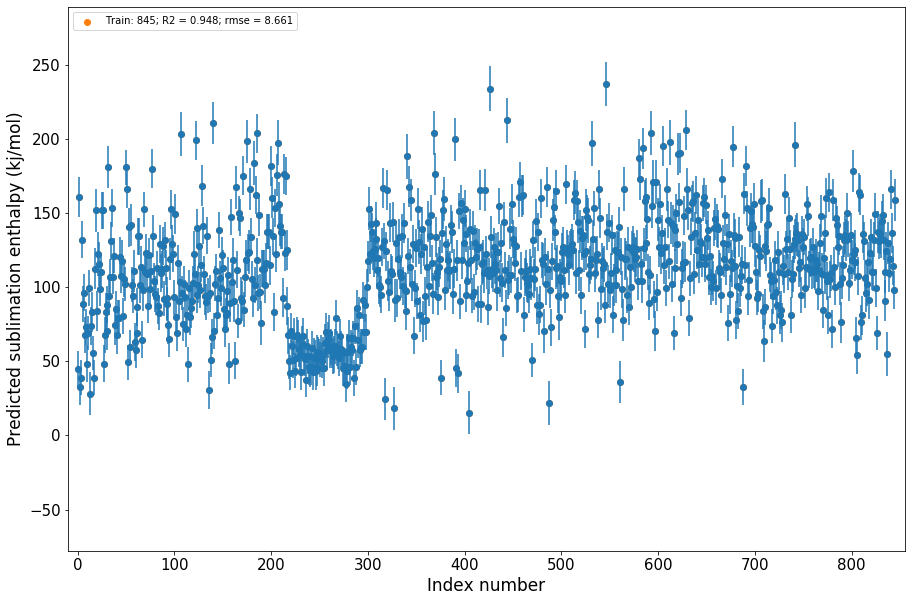

In [5]:
# Visualize the prediction
import matplotlib.pyplot as plt

label_train = 'Train: 845; R2 = ' + str('%.3f' % R2_train ) + '; rmse = ' + str('%.3f' % rmse_train) #'%.3f' % R2_train_ 小数点后保留三位

plt.figure(figsize=(15, 10))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#设置图片大小，tick大小

lim_min = min(min(Y_train), min(y_train))     
lim_max = max(max(Y_train), max(y_train))
lim = [lim_min - (lim_max - lim_min) * 0.4, lim_max + (lim_max - lim_min) * 0.2] 
limx_max=max(X_train_series)
print(limx_max)
limx = [-10, limx_max +10]
plt.xlim(limx)
plt.ylim(lim)


plt.xlabel("Index number", size=17)
plt.ylabel("Predicted sublimation enthalpy (kj/mol)", size=17)


plots_ = list()
plot_train = plt.scatter(X_train_series, y_train, color='tab:orange', marker='o', label="train")
plots_.append(plot_train)

#errorbar
y_trainerr=y_train_std[1]
plt.errorbar(X_train_series, y_train, yerr=y_trainerr,color='tab:blue',fmt='o')

plt.legend(handles=[plot_train],labels=[label_train],loc='upper left')


plt.savefig('./sublimation enthalpy_845.jpg')                                       ############################

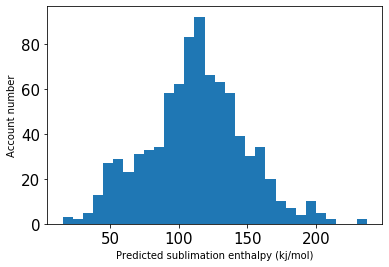

In [6]:
import matplotlib
%matplotlib inline
plt.hist(y_train, color='tab:blue', bins=30)  # density=False would make counts
#plt.axis([0, 557, 0, 250])  #axis([xmin,xmax,ymin,ymax])
plt.ylabel('Account number')
plt.xlabel('Predicted sublimation enthalpy (kj/mol)')

plt.savefig('./845_train_histogram.jpg')                                       ############################

plt.show()